In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import torchvision
import torch.nn as nn
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.patches as patches
import os

In [2]:

def generate_box(obj):
    
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 2
    elif obj.find('name').text == "mask_weared_incorrect":
        return 3
    return 1

def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')
        num_objs = len(objects)
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        img_id = torch.tensor([image_id])
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target


In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
imgs = list(sorted(os.listdir("/content/gdrive/MyDrive/images")))


In [5]:
labels = list(sorted(os.listdir("/content/gdrive/MyDrive/annotations")))

In [6]:
class MaskDataset(object):
    def __init__(self, transforms):
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir("/content/gdrive/MyDrive/images")))
        self.labels = list(sorted(os.listdir("/content/gdrive/MyDrive/annotations")))

    def __getitem__(self, idx):
        file_image = 'maksssksksss'+ str(idx) + '.png'
        file_label = 'maksssksksss'+ str(idx) + '.xml'
        img_path = os.path.join("/content/gdrive/MyDrive/images/", file_image)
        label_path = os.path.join("/content/gdrive/MyDrive/annotations/", file_label)
        img = Image.open(img_path).convert("RGB")
        target = generate_target(idx, label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [7]:
data_transform = transforms.Compose([
        transforms.ToTensor(), 
    ])

In [8]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform)
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=4, collate_fn=collate_fn)

In [9]:
torch.cuda.is_available()

True

# Model

In [155]:
def model_detection(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [156]:
model = model_detection(4)

In [207]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{q: w.to(device) for q, w in n.items()} for n in annotations]
    break

# Train Model

In [158]:
num_epochs = 10
model.to(device)

parameter = [p for p in model.parameters() if p.requires_grad]
opt = torch.optim.SGD(parameter, lr=0.005, momentum=0.5, weight_decay=0.0005, nesterov=True)
history = []

for epoch in range(num_epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{q: w.to(device) for q, w in n.items()} for n in annotations]
        loss_dt = model([imgs[0]], [annotations[0]])
        loss = sum(los for los in loss_dt.values())   

        opt.zero_grad()
        loss.backward()
        opt.step()
        scheduler.step(loss)
        print(f'Iteration: {i}/{(len(data_loader))}, Loss: {loss}')
        epoch_loss += loss
    history.append(epoch_loss/i)
    print(f'epoch: {epoch} losse: {epoch_loss/i}')


Iteration: 1/214, Loss: 1.9060823917388916
Iteration: 2/214, Loss: 0.6518685221672058
Iteration: 3/214, Loss: 0.31580594182014465
Iteration: 4/214, Loss: 0.9718728065490723
Iteration: 5/214, Loss: 0.285317063331604
Iteration: 6/214, Loss: 0.43438488245010376
Iteration: 7/214, Loss: 0.168382927775383
Iteration: 8/214, Loss: 0.37834298610687256
Iteration: 9/214, Loss: 0.47223222255706787
Iteration: 10/214, Loss: 1.30587637424469
Iteration: 11/214, Loss: 1.039402723312378
Iteration: 12/214, Loss: 0.9739057421684265
Iteration: 13/214, Loss: 0.2787731885910034
Iteration: 14/214, Loss: 1.763237714767456
Iteration: 15/214, Loss: 0.3487964868545532
Iteration: 16/214, Loss: 0.3500989079475403
Iteration: 17/214, Loss: 2.0420196056365967
Iteration: 18/214, Loss: 0.20631244778633118
Iteration: 19/214, Loss: 0.2220882773399353
Iteration: 20/214, Loss: 0.6706085205078125
Iteration: 21/214, Loss: 0.2614218592643738
Iteration: 22/214, Loss: 0.577271044254303
Iteration: 23/214, Loss: 0.3149286210536957

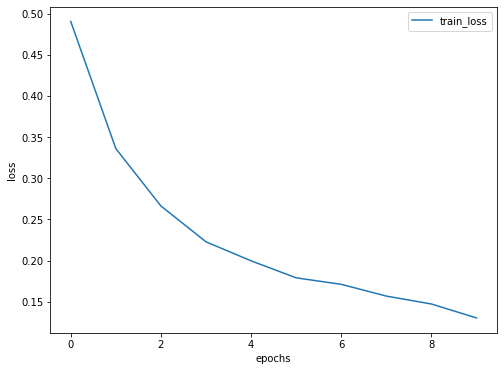

In [162]:
plt.figure(figsize=(8, 6))
plt.plot(history, label="train_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [163]:
i=0
for imgs, annotations in data_loader:
        i+=1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{q: w.to(device) for q, w in n.items()} for n in annotations]
        if i == 32:
          break

In [169]:
model.eval()
predict = model(imgs)

# Function to plot image

In [204]:
def plot_image(img_tensor, min_score, annotation):
  fig,ax = plt.subplots(1, figsize=(8, 8))
  img = img_tensor.cpu().data

  ax.imshow(img.permute(1, 2, 0))
  dict_class = {1: 'no_mask', 2: 'mask', 3: 'inc_mask'}
  dict_color = {1: 'r', 2: 'g', 3: 'b'}
  spisok = [1, 2, 3]
  k = 0
  for box in annotation["boxes"]:
    xmin, ymin, xmax, ymax = box
    clas = 'None'
    for i in range(3):
      if int(annotation["labels"][k]) == spisok[i]:
        try:
          if annotation["scores"][k] > min_score:
            clas = dict_class[i+1] + ':' + str(round(float(annotation["scores"][k]),2))
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor=dict_color[i+1],facecolor='none')
        except:
          clas = dict_class[i+1]
          rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor=dict_color[i+1],facecolor='none')

    if clas != 'None':
      plt.text(xmax, ymax, f'{clas}', size=(xmax-xmin)/12, rotation=0.,
      ha="right", va="top",
      bbox=dict(boxstyle="square",
                ec=(1., 0.5, 0.5),
                fc=(1., 0.8, 0.8),
               )
      )
    ax.add_patch(rect)
    k += 1 

Prediction
Target


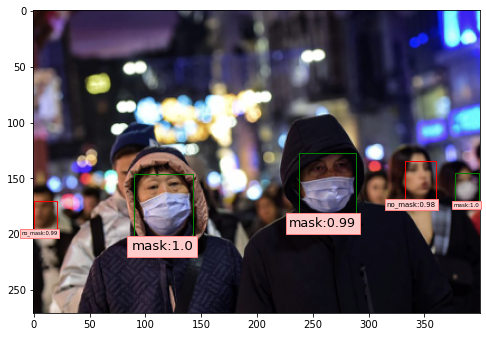

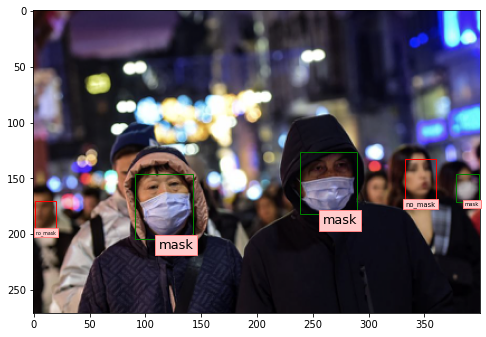

In [203]:
print("Prediction")
plot_image(imgs[0], 0.6, predict[0])
print("Target")
plot_image(imgs[0], 0.6, annotations[0])


# Uploading your own images

In [177]:
class Own_images(object):
    def __init__(self, transforms, filename):
        self.transforms = transforms
        self.filename = filename

    def __getitem__(self, idx):
        img_path = os.path.join("/content/gdrive/MyDrive/test_images/", self.filename)
        img = Image.open(img_path).convert("RGB")
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img

    def __len__(self):
        return len(self.imgs)

In [187]:
dataset_test = Own_images(data_transform,  'RIAN_6197665.HR-pic4_zoom-1500x1500-91838.jpg')
own_img = [dataset_test[0]]
own_img = list(img.to(device) for img in own_img)
model.eval()
preds = model(own_img)

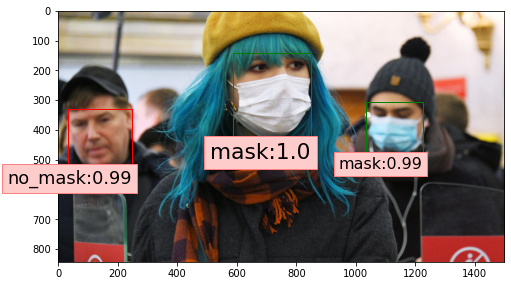

In [206]:
plot_image(own_img[0], 0.6, preds[0])